In [356]:
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree, ensemble, svm

# IPython
from IPython.display import Audio, display

# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, InputLayer, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import RMSprop

%load_ext autoreload
%autoreload 2

from utils import *
from dataset_loader import DatasetLoader
from plot_confusion_matrix import plot_confusion_matrix



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Spectral features

In [357]:
FEATURES_DIR = "../features/spectral_feat_fs_44100_window_4096_hop_512/"
META_FILE = '../meta/esc50.csv'
DATASET_DIR = '../audio/'

### Load dataset

In [359]:
dataset_loader = DatasetLoader(FEATURES_DIR, META_FILE, test_fold = 1, category_idx=0)
dataset_loader.load()
# normalize data
# dataset_loader.normalize()

Time taken to load = 0.19


### Visualize features

In [360]:
def play_audio(dataset_loader, idx):
    row = dataset_loader.df_train.iloc[idx]    
    category = row.category
    filename = row.filename
    print(category, filename)
    display(Audio(os.path.join(DATASET_DIR, filename)))


In [361]:
def plot_features(ax, dataset_loader, idx, audio=False):
    row = dataset_loader.df_train.iloc[idx]
    feat = row.feat
    category = row.category
    filename = row.filename

    # convert hop size to time
    hop_to_time = np.arange(feat.shape[1]) * 256.0 / 22050.0
    hop_to_time = hop_to_time.round(decimals=2)
    # plot
    ax.plot(hop_to_time, feat.T)
    ax.legend(['centroid', 'bandwidth', 'flatness', 'rolloff'])
    ax.set_xlabel('time (s)')
    ax.set_title(category)


In [363]:
play_audio(dataset_loader, 21)

dog 2-116400-A-0.wav


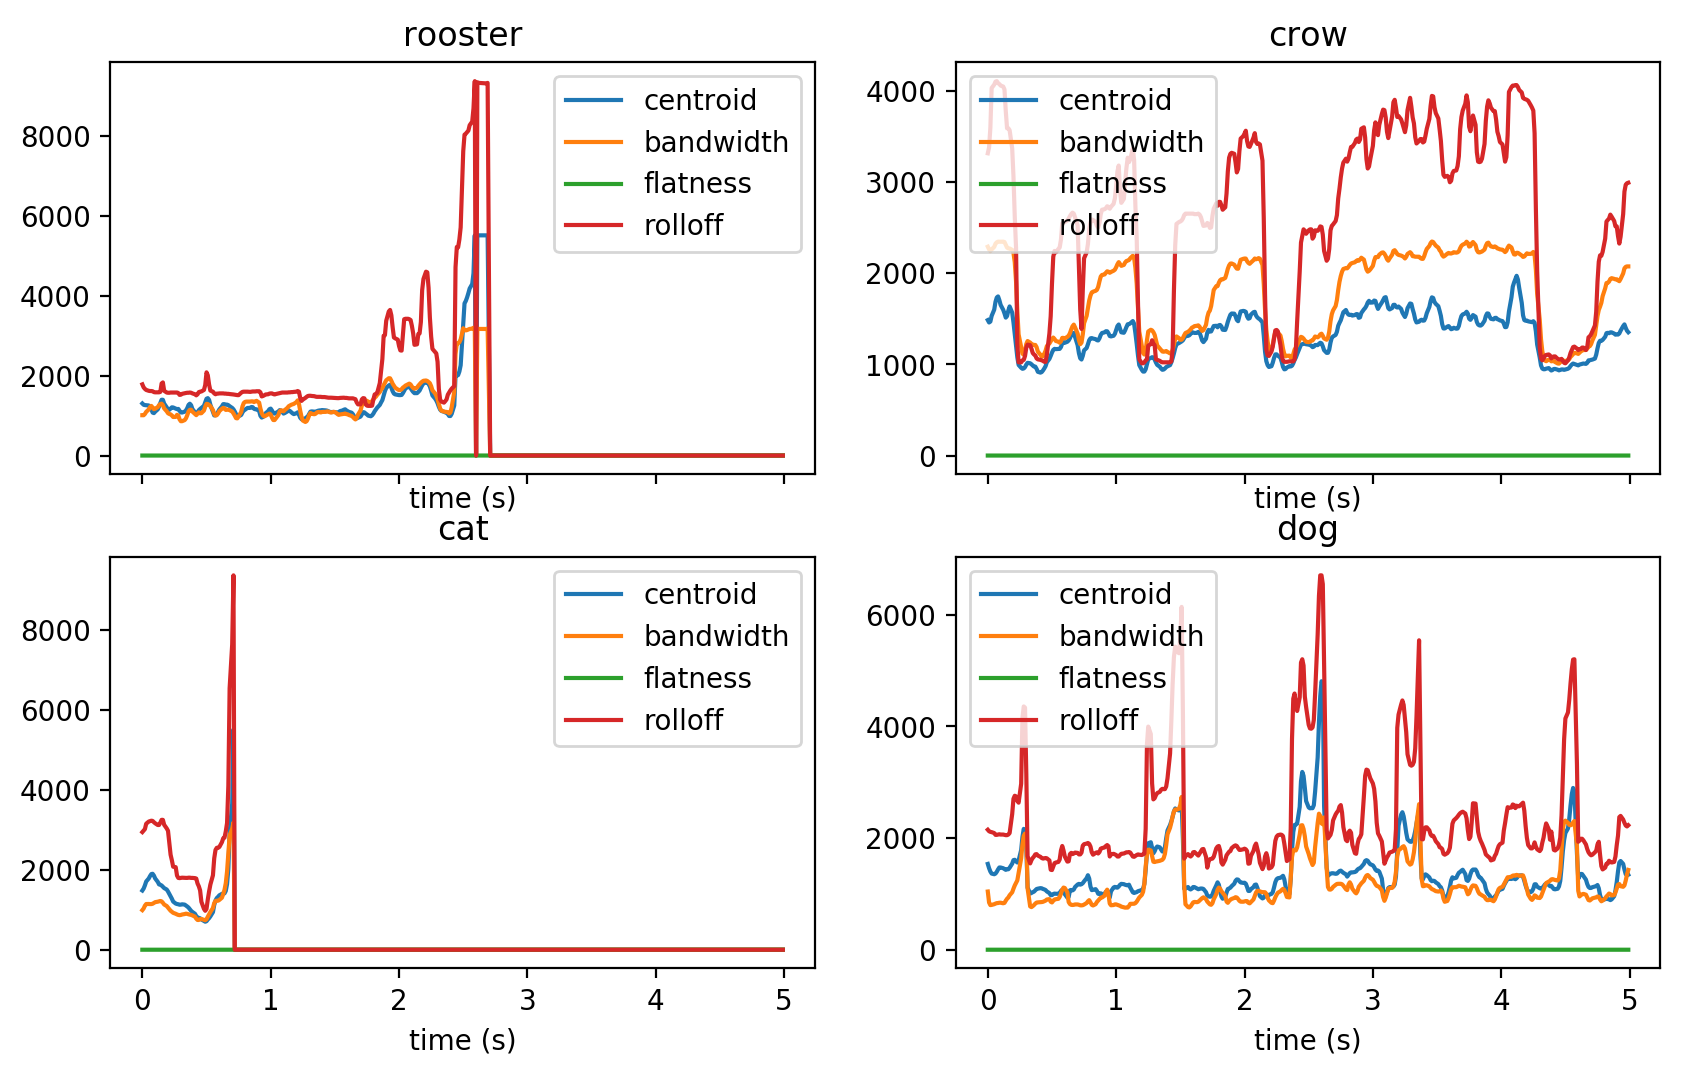

In [423]:
fig, ax = plt.subplots(2,2, figsize=(10,6), sharex=True, dpi=200)
plot_features(ax[0,0], dataset_loader, 0)
plot_features(ax[0,1], dataset_loader, 8)
plot_features(ax[1,0], dataset_loader, 15)
plot_features(ax[1,1], dataset_loader, 20)

In [429]:
X_train, y_train = dataset_loader.get_train_data()
X_test, y_test = dataset_loader.get_test_data()

### Method  1
Just using centroid


In [431]:
# select centroid
X_train = X_train[:,::4,:].squeeze()
X_test = X_test[:,::4,:].squeeze()

# get mean and std 
m = X_train.mean(axis=0)
s = X_train.std(axis=0)

X_train = (X_train - m) / s
X_test = (X_test - m) / s
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 431), (320,), (80, 431), (80,))

### Method 2
concatination of all features

In [403]:
# flatten all features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

# get mean and std 
m = X_train.mean(axis=0)
s = X_train.std(axis=0)

X_train = (X_train - m) / s
X_test = (X_test - m) / s
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 1724), (320,), (80, 1724), (80,))

### Method  3
Mean and standard deviation of all the features

In [399]:
X_train = np.concatenate([X_train.mean(axis=2), X_train.std(axis=2)], axis=1)
X_test = np.concatenate([X_test.mean(axis=2), X_test.std(axis=2)], axis=1)

### Decision tree


In [432]:
clf = tree.DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.2125)

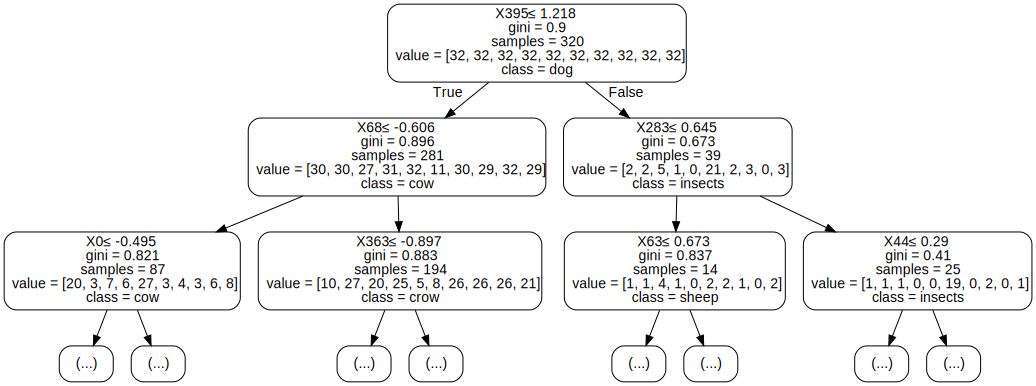

In [433]:
# visualize decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image,SVG
from sklearn.tree import export_graphviz
from graphviz import Source
import pydotplus
dot_data = StringIO()
export_graphviz(clf, class_names=dataset_loader.classes, 
                out_file=dot_data,  
                filled=False, rounded=True,
                special_characters=True, max_depth=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())
SVG(graph.create_svg())

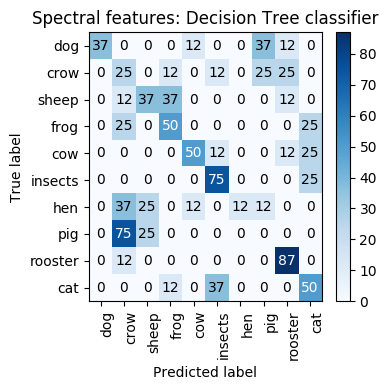

In [334]:
y_test_pred = clf.predict(X_test)

plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize=True, figsize=(4,4),
                      classes=dataset_loader.classes, title='Spectral features: Decision Tree classifier')

### Random forest

In [434]:
clf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=25)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.2875)

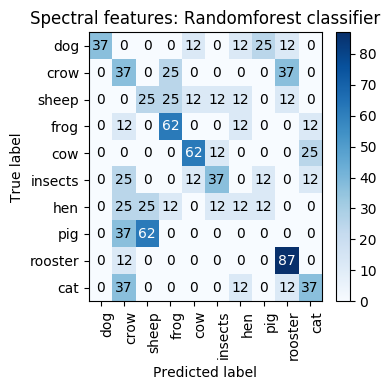

In [389]:
y_test_pred = clf.predict(X_test)

plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize=True, figsize=(4,4),
                      classes=dataset_loader.classes, title='Spectral features: Randomforest classifier')

### KNN

In [407]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.309375, 0.275)

### SVM

In [408]:
clf = svm.SVC()
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.575, 0.225)

### MLP

In [435]:
# keras training settings
batch_size = 32
num_classes = 50
epochs = 40

# mlp
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               55296     
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 50)                6450      
Total para

In [436]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

history = model.fit(X_train, y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test_cat))

Train on 320 samples, validate on 80 samples
Epoch 1/40
 - 1s - loss: 4.0986 - acc: 0.0312 - val_loss: 3.4672 - val_acc: 0.1250
Epoch 2/40
 - 0s - loss: 3.3886 - acc: 0.1156 - val_loss: 3.0069 - val_acc: 0.1500
Epoch 3/40
 - 0s - loss: 3.0019 - acc: 0.1531 - val_loss: 2.7848 - val_acc: 0.1750
Epoch 4/40
 - 0s - loss: 2.6949 - acc: 0.2125 - val_loss: 2.5020 - val_acc: 0.1875
Epoch 5/40
 - 0s - loss: 2.5333 - acc: 0.1875 - val_loss: 2.3898 - val_acc: 0.1875
Epoch 6/40
 - 0s - loss: 2.4809 - acc: 0.2188 - val_loss: 2.4004 - val_acc: 0.2125
Epoch 7/40
 - 0s - loss: 2.4005 - acc: 0.2000 - val_loss: 2.3756 - val_acc: 0.2125
Epoch 8/40
 - 0s - loss: 2.3277 - acc: 0.2406 - val_loss: 2.3261 - val_acc: 0.1875
Epoch 9/40
 - 0s - loss: 2.2964 - acc: 0.2219 - val_loss: 2.2496 - val_acc: 0.2750
Epoch 10/40
 - 0s - loss: 2.2667 - acc: 0.2625 - val_loss: 2.3159 - val_acc: 0.2375
Epoch 11/40
 - 0s - loss: 2.1602 - acc: 0.2875 - val_loss: 2.1691 - val_acc: 0.2750
Epoch 12/40
 - 0s - loss: 2.1514 - acc: 